In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<Container object of 3 artists>

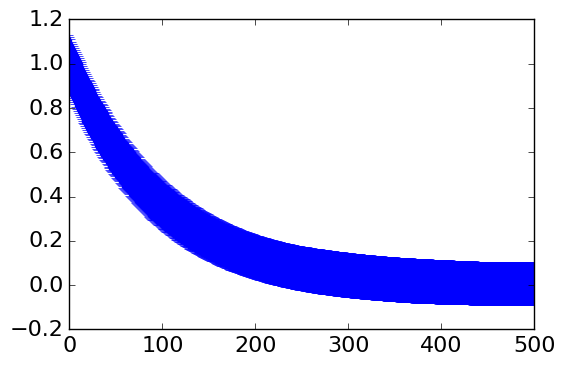

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

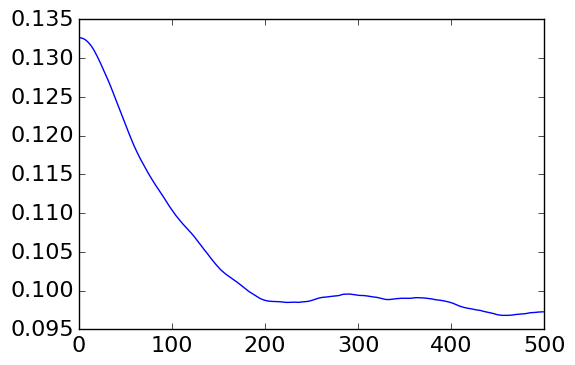

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
result_array = None
for y in acf_all:
    print("***** Iteration ",i," *****")
    mod = ExponentialModel()
    pars = mod.guess(y, x=t)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            np.sqrt(out.covar[1,1])*delta_t,
                            out.values['amplitude'],
                            np.sqrt(out.covar[0,0])])
        print(out.fit_report(min_correl=0.25))
        
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            np.sqrt(out2.covar[1,1])*delta_t,
                            out2.values['amplitude'],
                            np.sqrt(out2.covar[0,0])])
        print(out2.fit_report(min_correl=0.25))

    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 0.380
    reduced chi-square = 0.001
    Akaike info crit   = -3585.708
    Bayesian info crit = -3577.279
[[Variables]]
    amplitude:   0.80861652 +/- 0.005487 (0.68%) (init= 0.9128493)
    decay:       99.3939795 +/- 0.959985 (0.97%) (init= 92.62367)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 500
    # variables        = 2
    chi-square         = 36.892
    reduced chi-square = 0.074
    Akaike info crit   = -1297.304
    Bayesian info crit = -1288.875
[[Variables]]
    amplitude:   0.79842634 +/- 0.006695 (0.84%) (init= 0.9128493)
    decay:       101.268806 +/- 1.056128 (1.04%) (init= 92.62367)
[[Correlations]] (unreported correlations

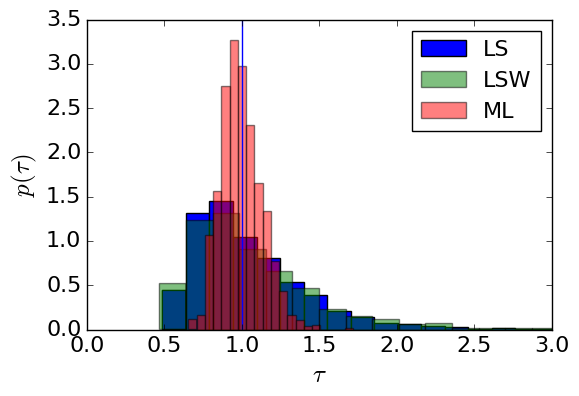

In [22]:
# decay time
plt.hist(result_array.T[0],normed=True,bins=20,label="LS")
plt.hist(result_array.T[4],normed=True,alpha=0.5,bins=20,label="LSW")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.5,bins=20,label="ML")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist.pdf",bbox_inches='tight')

In [10]:
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS std (fit):",result_array.T[1].mean())
print("Decay time LSW std (real):",result_array.T[4].std())
print("Decay time LSW std (fit):",result_array.T[5].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS std (real): 0.390589178097
Decay time LS std (fit): 0.0164793248517
Decay time LSW std (real): 0.438253657312
Decay time LSW std (fit): 0.0182667150397
Decay time Bayes std (real): 0.133071096251
Decay time Bayes std (fit): 0.141744498927


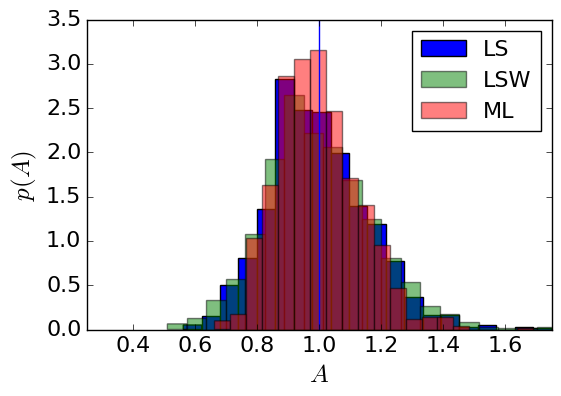

In [21]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS")
plt.hist(result_array.T[6],normed=True,alpha=0.5,bins=20,label="LSW")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.5,bins=20,label="ML")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist.pdf",bbox_inches='tight')

In [12]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS std (fit):",result_array.T[3].mean())
print("Amplitude LSW std (real):",result_array.T[6].std())
print("Amplitude LSW std (fit):",result_array.T[7].mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.99840823198
Amplitude LS std (real): 0.161818604173
Amplitude LS std (fit): 0.0114501917654
Amplitude LSW std (real): 0.175921003803
Amplitude LSW std (fit): 0.0142677165651
Amplitude Bayes mean (real): 0.997443255947
Amplitude Bayes std (real): 0.131827476656
Amplitude Bayes std (fit): 0.141053587623


(0.31829825170931447, 5.5730766538872188e-25)


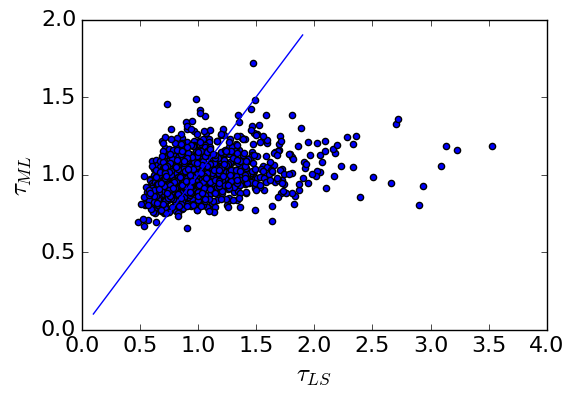

In [20]:
#decay correlation
plt.scatter(result_array.T[0],result_Bayes_array.T[2])
plt.plot([0.1,1.9],[0.1,1.9])
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr.pdf",bbox_inches='tight')

(0.8370021750199319, 1.4086477548484004e-263)


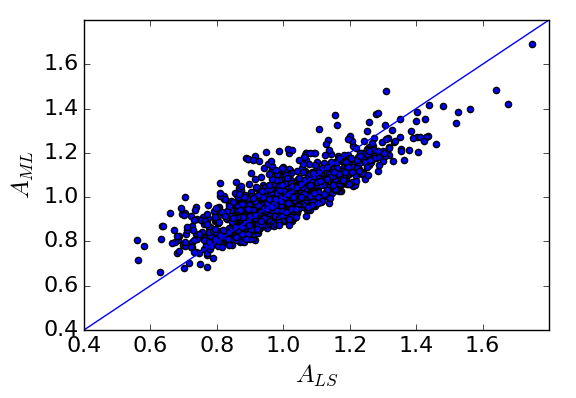

In [19]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
plt.plot([0,1.8],[0,1.8])
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr.pdf",bbox_inches='tight')

In [15]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],result_array.T[3],result_array.T[0],result_array.T[1]):
    print(i,a,da,t,dt)

0 0.808616529435 0.0054876784265 0.993939795158 0.00959985066282
1 0.738387281454 0.0144286886993 1.65977251622 0.0474326337811
2 0.818995048349 0.00835205538196 1.21615558555 0.017711703525
3 1.17742438346 0.0086061766943 0.869673357308 0.00904451719558
4 1.04378566415 0.0142180602777 0.667440109921 0.0129553622198
5 0.883051555351 0.00869744254439 0.743184172944 0.0104224907687
6 0.998668075313 0.00526645334975 0.828941709191 0.0062209131625
7 0.870560951989 0.00731449432022 1.27617222347 0.0153410559093
8 1.04694218044 0.0049210449624 1.06667168018 0.0071400521535
9 0.870522120625 0.00509564750935 1.40464742539 0.0118263411436
10 1.21032306002 0.0219405783376 0.645006662165 0.0166669989124
11 1.067835111 0.0119170536505 1.58989858403 0.0258062188502
12 1.04663550975 0.0123725374513 1.69649226112 0.0294080334273
13 0.965294923836 0.00922364195374 1.78911848184 0.0252756011023
14 0.759784515315 0.00537206123824 1.564746405 0.0160629227936
15 0.842851288327 0.00556479280832 1.026033932

In [16]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

0.00E+00
-1826.885444
0.398942280401
0.00E+00
-917.93537993


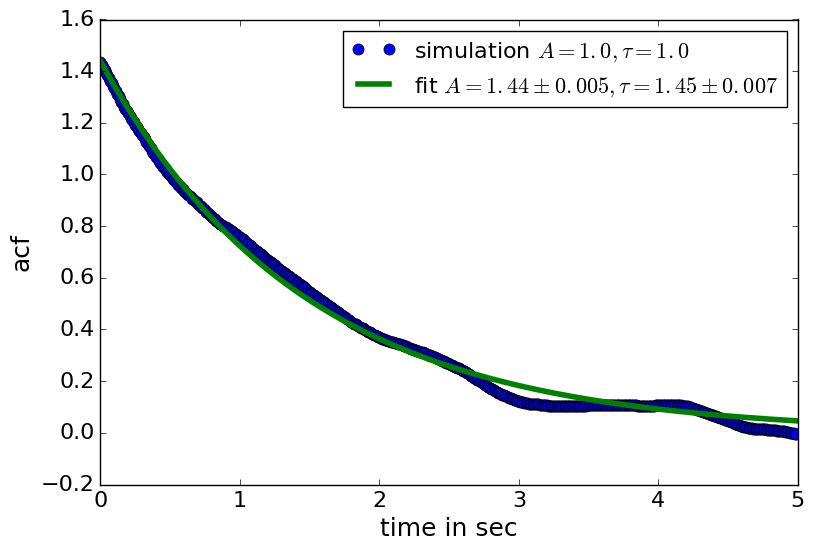

In [18]:
plt.figure(figsize=(9,6))
plt.plot(t,acf,"o",markersize=8,label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,linewidth=4,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$")
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit.pdf",bbox_inches='tight')